[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Conversational Memory

## Extra Material: Token Counter

This is an additional piece of material alongside the [LangChain Handbook notebook on Conversational Memory](https://github.com/pinecone-io/examples/blob/master/generation/langchain/handbook/03-langchain-conversational-memory.ipynb).

In this notebook we will count the number of tokens used in a conversation for different conversational memory types.

We begin by installing the required libraries:

In [1]:
!pip install -qU langchain openai transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.5 MB/s eta 0:00:00


Import required libraries and objects:

In [2]:
from getpass import getpass

import openai
from langchain import OpenAI
from langchain.chains import LLMChain, ConversationChain
from langchain.chains.conversation.memory import (
    ConversationBufferMemory,
    ConversationSummaryMemory,
    ConversationBufferWindowMemory,
    ConversationSummaryBufferMemory
)
from langchain.callbacks import get_openai_callback
from tqdm.auto import tqdm

To run the notebook we'll use OpenAI's `gpt-3.5-turbo` model. We initialize it via LangChain like so:

In [3]:
OPENAI_API_KEY = getpass()

··········


In [4]:
llm = OpenAI(
    temperature=0, 
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo'  # can be used with llms like 'text-davinci-003'
)

To count the number of tokens used during each call we will define a `count_tokens` function:

In [5]:
def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.run(query)
    return {
        'result': result,
        'token_count': cb.total_tokens
    }

Let's define the conversation function:

In [6]:
queries = [
    "Good morning AI?",
    """My interest here is to explore the potential of integrating Large
    Language Models with external knowledge""",
    "I just want to analyze the different possibilities. What can you think of?",
    "What about the use of retrieval augmentation, can that be used as well?",
    """That's very interesting, can you tell me more about this? Like what
    systems would I use to store the information and retrieve relevant info?""",
    """Okay that's cool, I've been hearing about 'vector databases', are they
    relevant in this context?""",
    """Okay that's useful, but how do I go from my external knowledge to
    creating these 'vectors'? I have no idea how text can become a vector?""",
    """Well I don't think I'd be using word embeddings right? If I wanted to
    store my documents in this vector database, I suppose I would need to
    transform the documents into vectors? Maybe I can use the 'sentence
    embeddings' for this, what do you think?""",
    """Can sentence embeddings only represent sentences of text? That seems
    kind of small to capture any meaning from a document? Is there any approach
    that can encode at least a paragraph of text?""",
    """Huh, interesting. I do remember reading something about 'mpnet' or
    'minilm' sentence 'transformer' models that could encode small to
    medium sized paragraphs. Am I wrong about this?""",
    """Ah that's great to hear, do you happen to know how much text I can feed
    into these types of models?""",
    """I've never heard of hierarchical embeddings, could you explain those in
    more detail?""",
    """So is it like you have a transformer model or something else that creates
    sentence level embeddings, then you feed all of the sentence level
    embeddings into another separate neural network that knows how to merge
    multiple sentence embeddings into a single embedding?""",
    """Could you explain this process step by step from start to finish? Explain
    like I'm very new to this space, assume I don't have much prior knowledge
    of embeddings, neural nets, etc""",
    """Awesome thanks! Are there any popular 'heirarchical neural network'
    models that I can look up? Or maybe just the second stage that creates the
    hierarchical embeddings?""",
    "It seems like these HAN models are quite old, is there anything more recent?",
    "Can you explain the difference between transformer-XL and longformer?",
    "How much text can be encoded by each of these models?",
    """Okay very interesting, so before returning to earlier in the conversation.
    I understand now that there are a lot of different transformer (and not
    transformer) based models for creating the embeddings from vectors. Is that
    correct?""",
    """Perfect, so I understand text can be encoded into these embeddings. But
    what then? Once I have my embeddings what do I do?""",
    """I'd like to use these embeddings to help a chatbot or a question-answering
    system answer questions with help from this external knowledge base. I
    suppose this would come under information retrieval? Could you explain that
    process in a little more detail?""",
    """Okay great, that sounds like what I'm hoping to do. When you say the
    'chatbot or question-answering system generates an embedding', what do you
    mean exactly?""",
    """Ah okay, I understand, so it isn't the 'chatbot' model specifically
    creating the embedding right? That's how I understood your earlier comment.
    It seems more like there is a separate embedding model? And that encodes
    the query, then we retrieve the set of relevant documents from the
    external knowledge base? How is that information then used by the chatbot
    or question-answering system exactly?""",
    """Okay but how is the information provided to the chatbot or
    question-answering system?""",
    """So the retrieved information is given to the chatbot / QA system as plain
    text? But then how do we pass in the original query? How can the system
    distinguish between a user's query and all of this additional information?""",
    """That doesn't seem correct to me, my question is — if we are giving the
    chatbot / QA system the user's query AND retrieved information from an
    external knowledge base, and it's all fed into the model as plain text,
    how does the model know what part of the plain text is a query vs. retrieved
    information?""",
    """Yes I get that, but in the text passed to the model, how do we identify
    user prompt vs retrieved information?"""

]

def talk(conversation_chain):
    tokens_used = []
    # we loop through the conversation above, counting token usage as we go
    for user_query in tqdm(queries):
        try:
            res = count_tokens(conversation_chain, user_query)
            tokens_used.append(res['token_count'])
        except openai.error.InvalidRequestError:
            # we hit the token limit of the model, so break
            break
    return tokens_used

Create set of conversation chains that we'll be using:

In [7]:
conversation_chains = {
    'ConversationBufferMemory': ConversationChain(
        llm=llm, memory=ConversationBufferMemory()
    ),
    'ConversationSummaryMemory': ConversationChain(
        llm=llm, memory=ConversationSummaryMemory(llm=llm)
    ),
    'ConversationBufferWindowMemory(k=6)': ConversationChain(
        llm=llm, memory=ConversationBufferWindowMemory(k=6)
    ),
    'ConversationBufferWindowMemory(k=12)': ConversationChain(
        llm=llm, memory=ConversationBufferWindowMemory(k=12)
    ),
    'ConversationSummaryBufferMemory(k=6)': ConversationChain(
        llm=llm, memory=ConversationSummaryBufferMemory(
            llm=llm,
            max_token_limit=650
        )
    ),
    'ConversationSummaryBufferMemory(k=12)': ConversationChain(
        llm=llm, memory=ConversationSummaryBufferMemory(
            llm=llm,
            max_token_limit=1_300
        )
    )
}

In [8]:
counts = {}
# loop through each of our memory types above
for key, chain in conversation_chains.items():
    print(key)
    counts[key] = talk(chain)

ConversationBufferMemory


  0%|          | 0/27 [00:00<?, ?it/s]

ConversationSummaryMemory


  0%|          | 0/27 [00:00<?, ?it/s]

ConversationBufferWindowMemory(k=6)


  0%|          | 0/27 [00:00<?, ?it/s]

ConversationBufferWindowMemory(k=12)


  0%|          | 0/27 [00:00<?, ?it/s]

ConversationSummaryBufferMemory(k=6)


  0%|          | 0/27 [00:00<?, ?it/s]

ConversationSummaryBufferMemory(k=12)


  0%|          | 0/27 [00:00<?, ?it/s]

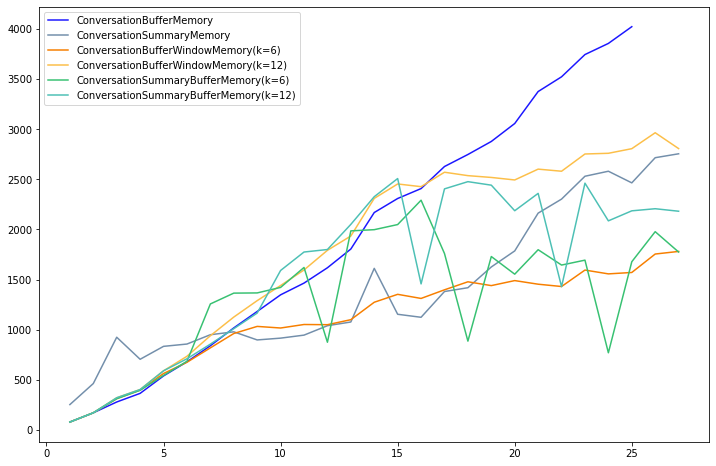

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.show()

---